<a href="https://colab.research.google.com/github/farisassallami/Seattle-Home-Prices-Unsupervised-Machine-Learning/blob/main/Seattle_House_prices_unsupervised_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Faris Assallami

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler ,MinMaxScaler
from sklearn.decomposition import PCA



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error



# Part 1: Clustering

## Loading Data

In [ ]:
df = pd.read_csv('/content/option_A_clustering_df - option_A_clustering_df.csv')

df.head()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,400000,1590,0,0,0,3180,1590,1590,0,600,...,0,220,0,6,0,2,1,1965,-122.196399,47.336118
1,474250,1390,0,0,0,2200,810,810,0,0,...,0,340,0,4,1,0,1,1945,-122.361913,47.509874
2,667950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2019,-122.156684,47.437557
3,659000,660,0,540,0,1820,620,620,0,0,...,0,100,0,3,1,0,2,2016,-122.370252,47.565146
4,656500,2310,0,0,0,2310,0,0,0,440,...,0,320,0,3,0,0,2,1967,-122.184194,47.730389


## Exploring and Cleaning the Data

### Checking data types

In [ ]:
df.info()
print('\n ---All data is numeric!---')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4944 entries, 0 to 4943
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SalePrice           4944 non-null   int64  
 1   SqFt1stFloor        4944 non-null   int64  
 2   SqFtHalfFloor       4944 non-null   int64  
 3   SqFt2ndFloor        4944 non-null   int64  
 4   SqFtUpperFloor      4944 non-null   int64  
 5   SqFtTotLiving       4944 non-null   int64  
 6   SqFtTotBasement     4944 non-null   int64  
 7   SqFtFinBasement     4944 non-null   int64  
 8   SqFtGarageBasement  4944 non-null   int64  
 9   SqFtGarageAttached  4944 non-null   int64  
 10  DaylightBasement    4944 non-null   int64  
 11  SqFtOpenPorch       4944 non-null   int64  
 12  SqFtEnclosedPorch   4944 non-null   int64  
 13  SqFtDeck            4944 non-null   int64  
 14  BrickStone          4944 non-null   int64  
 15  Bedrooms            4944 non-null   int64  
 16  BathHa

### Combining all square footage columns into total square footage column and dropping them

In [ ]:


df['TotalSqFt'] = df['SqFt1stFloor']+df['SqFtHalfFloor']+df['SqFt2ndFloor']+df['SqFtUpperFloor']+df['SqFtTotLiving']+df['SqFtTotBasement']+df['SqFtFinBasement']+df['SqFtGarageBasement']+df['SqFtGarageAttached']+df['SqFtOpenPorch']+df['SqFtEnclosedPorch']+df['SqFtDeck']

# Dropping 3 columns.
df = df.drop(columns=['SqFt1stFloor','SqFtHalfFloor','SqFt2ndFloor','SqFtUpperFloor','SqFtTotLiving','SqFtTotBasement','SqFtFinBasement','SqFtGarageBasement','SqFtGarageAttached','SqFtOpenPorch','SqFtEnclosedPorch','SqFtDeck'])

df.head()

,SalePrice,DaylightBasement,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude,TotalSqFt
0,400000,1,0,6,0,2,1,1965,-122.196399,47.336118,8820
1,474250,1,0,4,1,0,1,1945,-122.361913,47.509874,5550
2,667950,0,0,4,1,0,2,2019,-122.156684,47.437557,5617
3,659000,1,0,3,1,0,2,2016,-122.370252,47.565146,4360
4,656500,0,0,3,0,0,2,1967,-122.184194,47.730389,5420


### Checking for Missing values

In [ ]:
print(df.isna().sum())
print('\n---No missing values!---')

SalePrice           0
DaylightBasement    0
BrickStone          0
Bedrooms            0
BathHalfCount       0
Bath3qtrCount       0
BathFullCount       0
YrBuilt             0
Longitude           0
Latitude            0
TotalSqFt           0
dtype: int64

---No missing values!---


### Checking for Duplicates and deleting them.

In [ ]:
# Checking for duplicate
dup = df.duplicated().sum()
print(f'There are {dup} duplicate rows.')

# Removing duplicate rows
df.drop_duplicates(inplace = True)
dupl = df.duplicated().sum()
print(f"There are now {dupl} duplicate rows since we dropped them.")

There are 29 duplicate rows.
There are now 0 duplicate rows since we dropped them.


## Preparation for Clustering

### Initiating Scaler and transformer

In [ ]:
# Instantiate Standard Scaler
scaler = StandardScaler()

# Fit & transform data.
scaled_df = scaler.fit_transform(df)

### Elbow Plot

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'inertia')

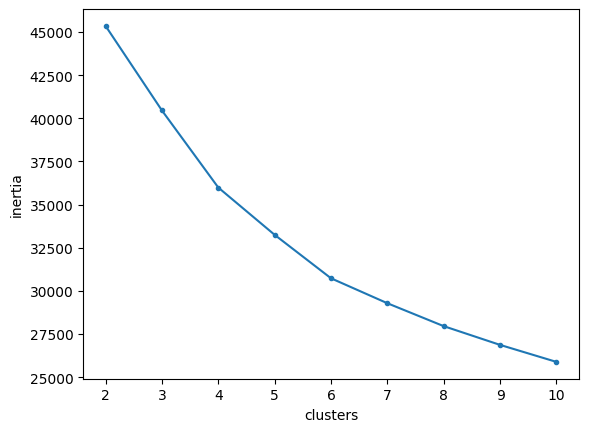

In [ ]:
#Creating an empty list of inertias
inertias = []

#Loop through i values between 2 and 10 and store the inertias in the list.
for i in range(2,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_df)
    inertias.append(kmeans.inertia_)

#Visualize scores
plt.plot(range(2,11), inertias, marker = '.')
plt.xlabel('clusters')
plt.ylabel('inertia')

### Silhouette  plot

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

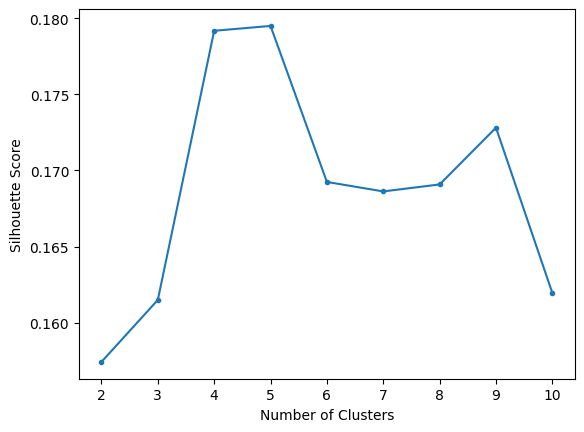

In [ ]:

# Saving silhouette scores for various cluster numbers in list
silhouette_scores = []
for i2 in range(2, 11):
  kmeanss = KMeans(n_clusters = i2)
  kmeanss.fit(scaled_df)
  silhouette_scores.append(silhouette_score(scaled_df, kmeanss.labels_))

# Visualizing scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

The Highest Silhouette Score is 4 and the elbow at the interia chart is at 4.  So I will choose 4 clusters.

## Using Kmeans

### Fitting kmeans model with 4 clusters and display the silhouette score

In [ ]:

kmeans4 = KMeans(n_clusters = 4)
kmeans4.fit(scaled_df)
silhouette_score(scaled_df, kmeans4.labels_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.1785538655709823

### Saving the cluster labels to the dataframe

In [ ]:

df['clusters'] = kmeans4.labels_

In [ ]:
cluster_groups = df.groupby('clusters', as_index=False).mean()



### Visualing the cluster means

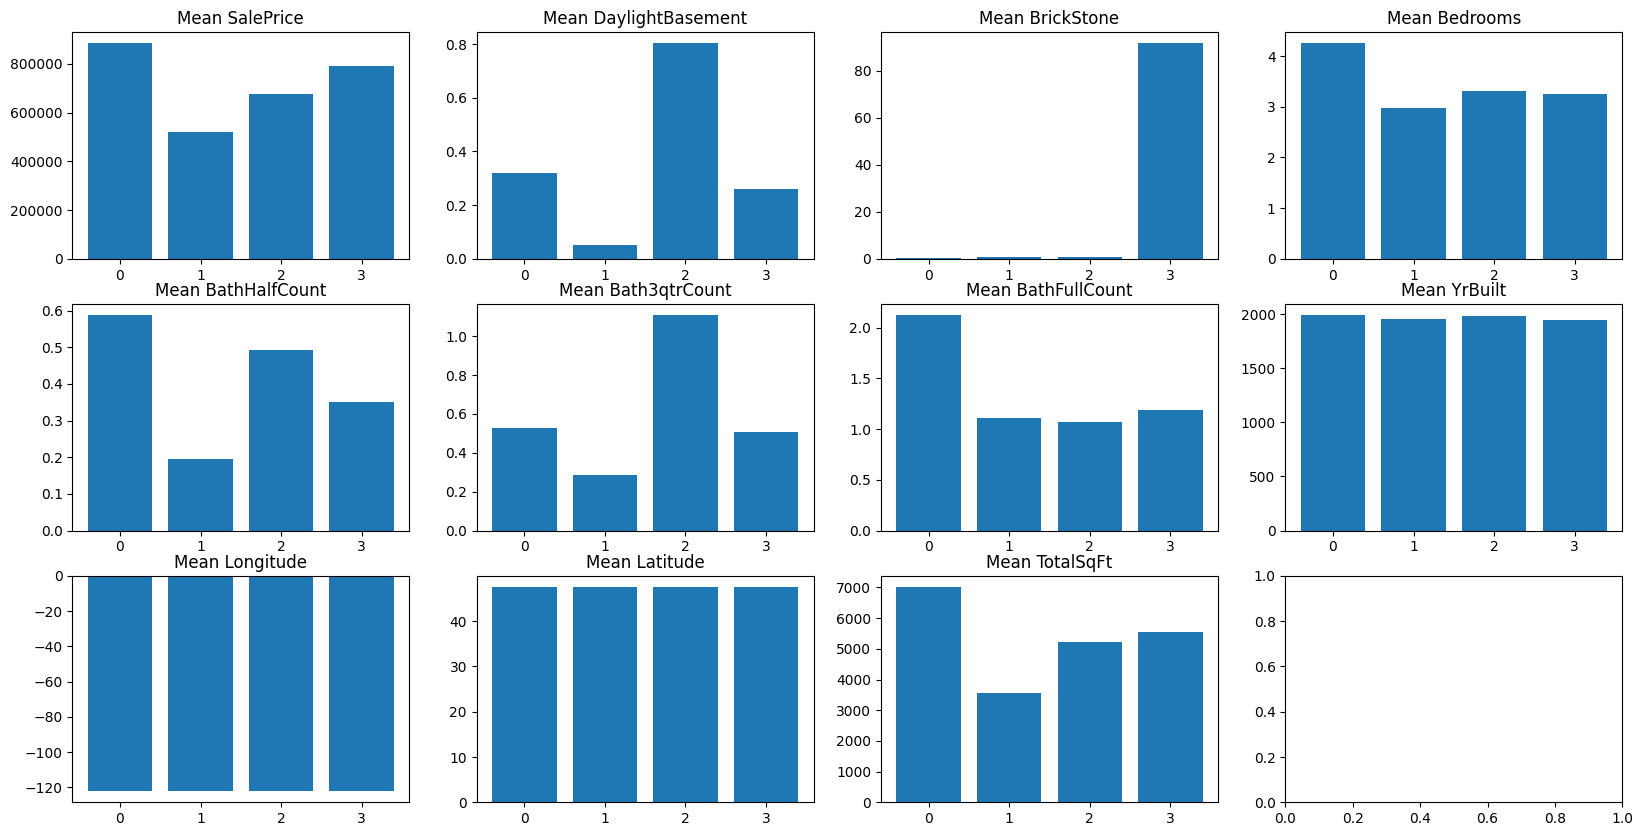

In [ ]:
# Visualize means
fig, axes = plt.subplots(3,4, figsize = (20, 10))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Looping over columns and plot each in a separate figure
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['clusters'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')



### Visualizing clusters means scatter plot SalesPrice vs TotalSqFt

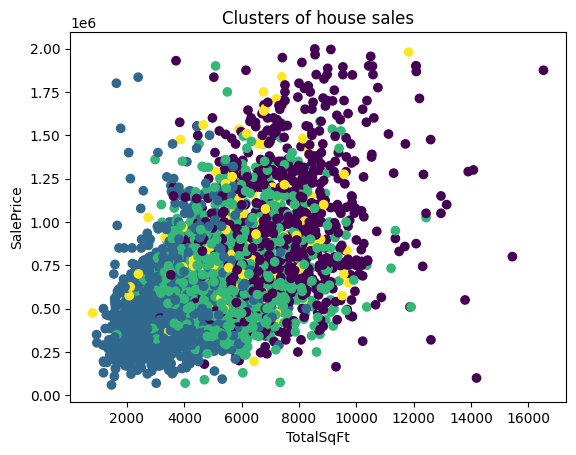

In [ ]:
plt.scatter(df['TotalSqFt'], df['SalePrice'], c = df['clusters'])
plt.xlabel('TotalSqFt')
plt.ylabel('SalePrice')
plt.title('Clusters of house sales');

We can see that Total Square Footage plays a role in Sale Price

### Visualizing clusters scatter plot SalesPrice vs YrBuilt

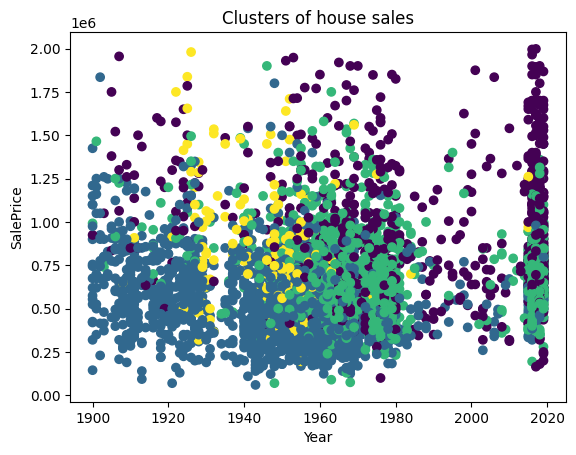

In [ ]:
plt.scatter(df['YrBuilt'], df['SalePrice'], c = df['clusters'])
plt.xlabel('Year')
plt.ylabel('SalePrice')
plt.title('Clusters of house sales');

We can see that certain clusters tend to Sell higher based on the year, most likely total Square Footage will play a role in determining sales price

### 3d Plot to visualize SalesPrice , YrBuilt, and TotalSqFt

In [ ]:
import plotly.express as px

px.scatter_3d(df, x= 'Bedrooms',
              y= 'SalePrice',
              z= 'YrBuilt',
              color='clusters')

In [ ]:
cluster_groups

,clusters,SalePrice,DaylightBasement,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude,TotalSqFt
0,0,885637.065482,0.319925,0.524790,4.254443,0.588400,0.525725,2.128157,1992.983162,-122.215354,47.555395,7028.329280
1,1,522108.698990,0.050505,0.759091,2.977273,0.195960,0.287879,1.109091,1951.887879,-122.290887,47.553043,3558.522727
2,2,676770.515897,0.803839,0.896821,3.312537,0.491302,1.109778,1.068986,1985.082783,-122.279817,47.601597,5227.454709
3,3,791647.688442,0.261307,91.824121,3.241206,0.351759,0.507538,1.185930,1947.718593,-122.313582,47.609506,5541.457286


-Cluster 0: Lowest average sale price, average year built around 1951 and least amount of total square footage

-Cluster 1: Third Lowest average sale price, average year built around 1985 and third lowest total square footage

-Cluster 2: Highest saverage sale price, average year built around 1992 and the highest total square footage

-Cluster 3: Second Highest average sale price, and they are the oldest average built home in 1947 but they have the second highest total square footage.

# Part 2: Modeling

## Loading the Data Set

In [ ]:
df2 = pd.read_csv('/content/option_A_clustering_df - option_A_clustering_df.csv')
df2.head()


,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,400000,1590,0,0,0,3180,1590,1590,0,600,...,0,220,0,6,0,2,1,1965,-122.196399,47.336118
1,474250,1390,0,0,0,2200,810,810,0,0,...,0,340,0,4,1,0,1,1945,-122.361913,47.509874
2,667950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2019,-122.156684,47.437557
3,659000,660,0,540,0,1820,620,620,0,0,...,0,100,0,3,1,0,2,2016,-122.370252,47.565146
4,656500,2310,0,0,0,2310,0,0,0,440,...,0,320,0,3,0,0,2,1967,-122.184194,47.730389


## Creating custom functions

In [ ]:
def eval_regression(model, X, y, name='model'):
    """Returns a dataframe with regression metrics.
    optional name variable can be used to name each model and/or dataset used
    for clarity"""
    score_df = pd.DataFrame(index=[name])
    preds = model.predict(X)
    score_df.loc[name,'MAE'] = mean_absolute_error(y, preds)
    score_df.loc[name,'RMSE'] = np.sqrt(mean_squared_error(y, preds))
    score_df.loc[name,'R2'] = r2_score(y, preds)
    return score_df

def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label='Train:'f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label='Test:'f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

## Preprocessing the data

### Setting target and features

In [ ]:
X = df2.drop(columns='SalePrice')
y = df2['SalePrice']

### Scaling the Data

In [ ]:
# Instantiate Standard Scaler
scalermnx = MinMaxScaler()
# Fitting & transforming data.
scaled_df2 = scalermnx.fit_transform(X)

### Applying PCA

In [ ]:
# This will help us determine the n_components we should use in ML
pca = PCA() # this is going generate 171 pcs

pca.fit(scaled_df2)

PCA()

### Visualizing scree plot

<ipython-input-28-ac26c89022a7>:3: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



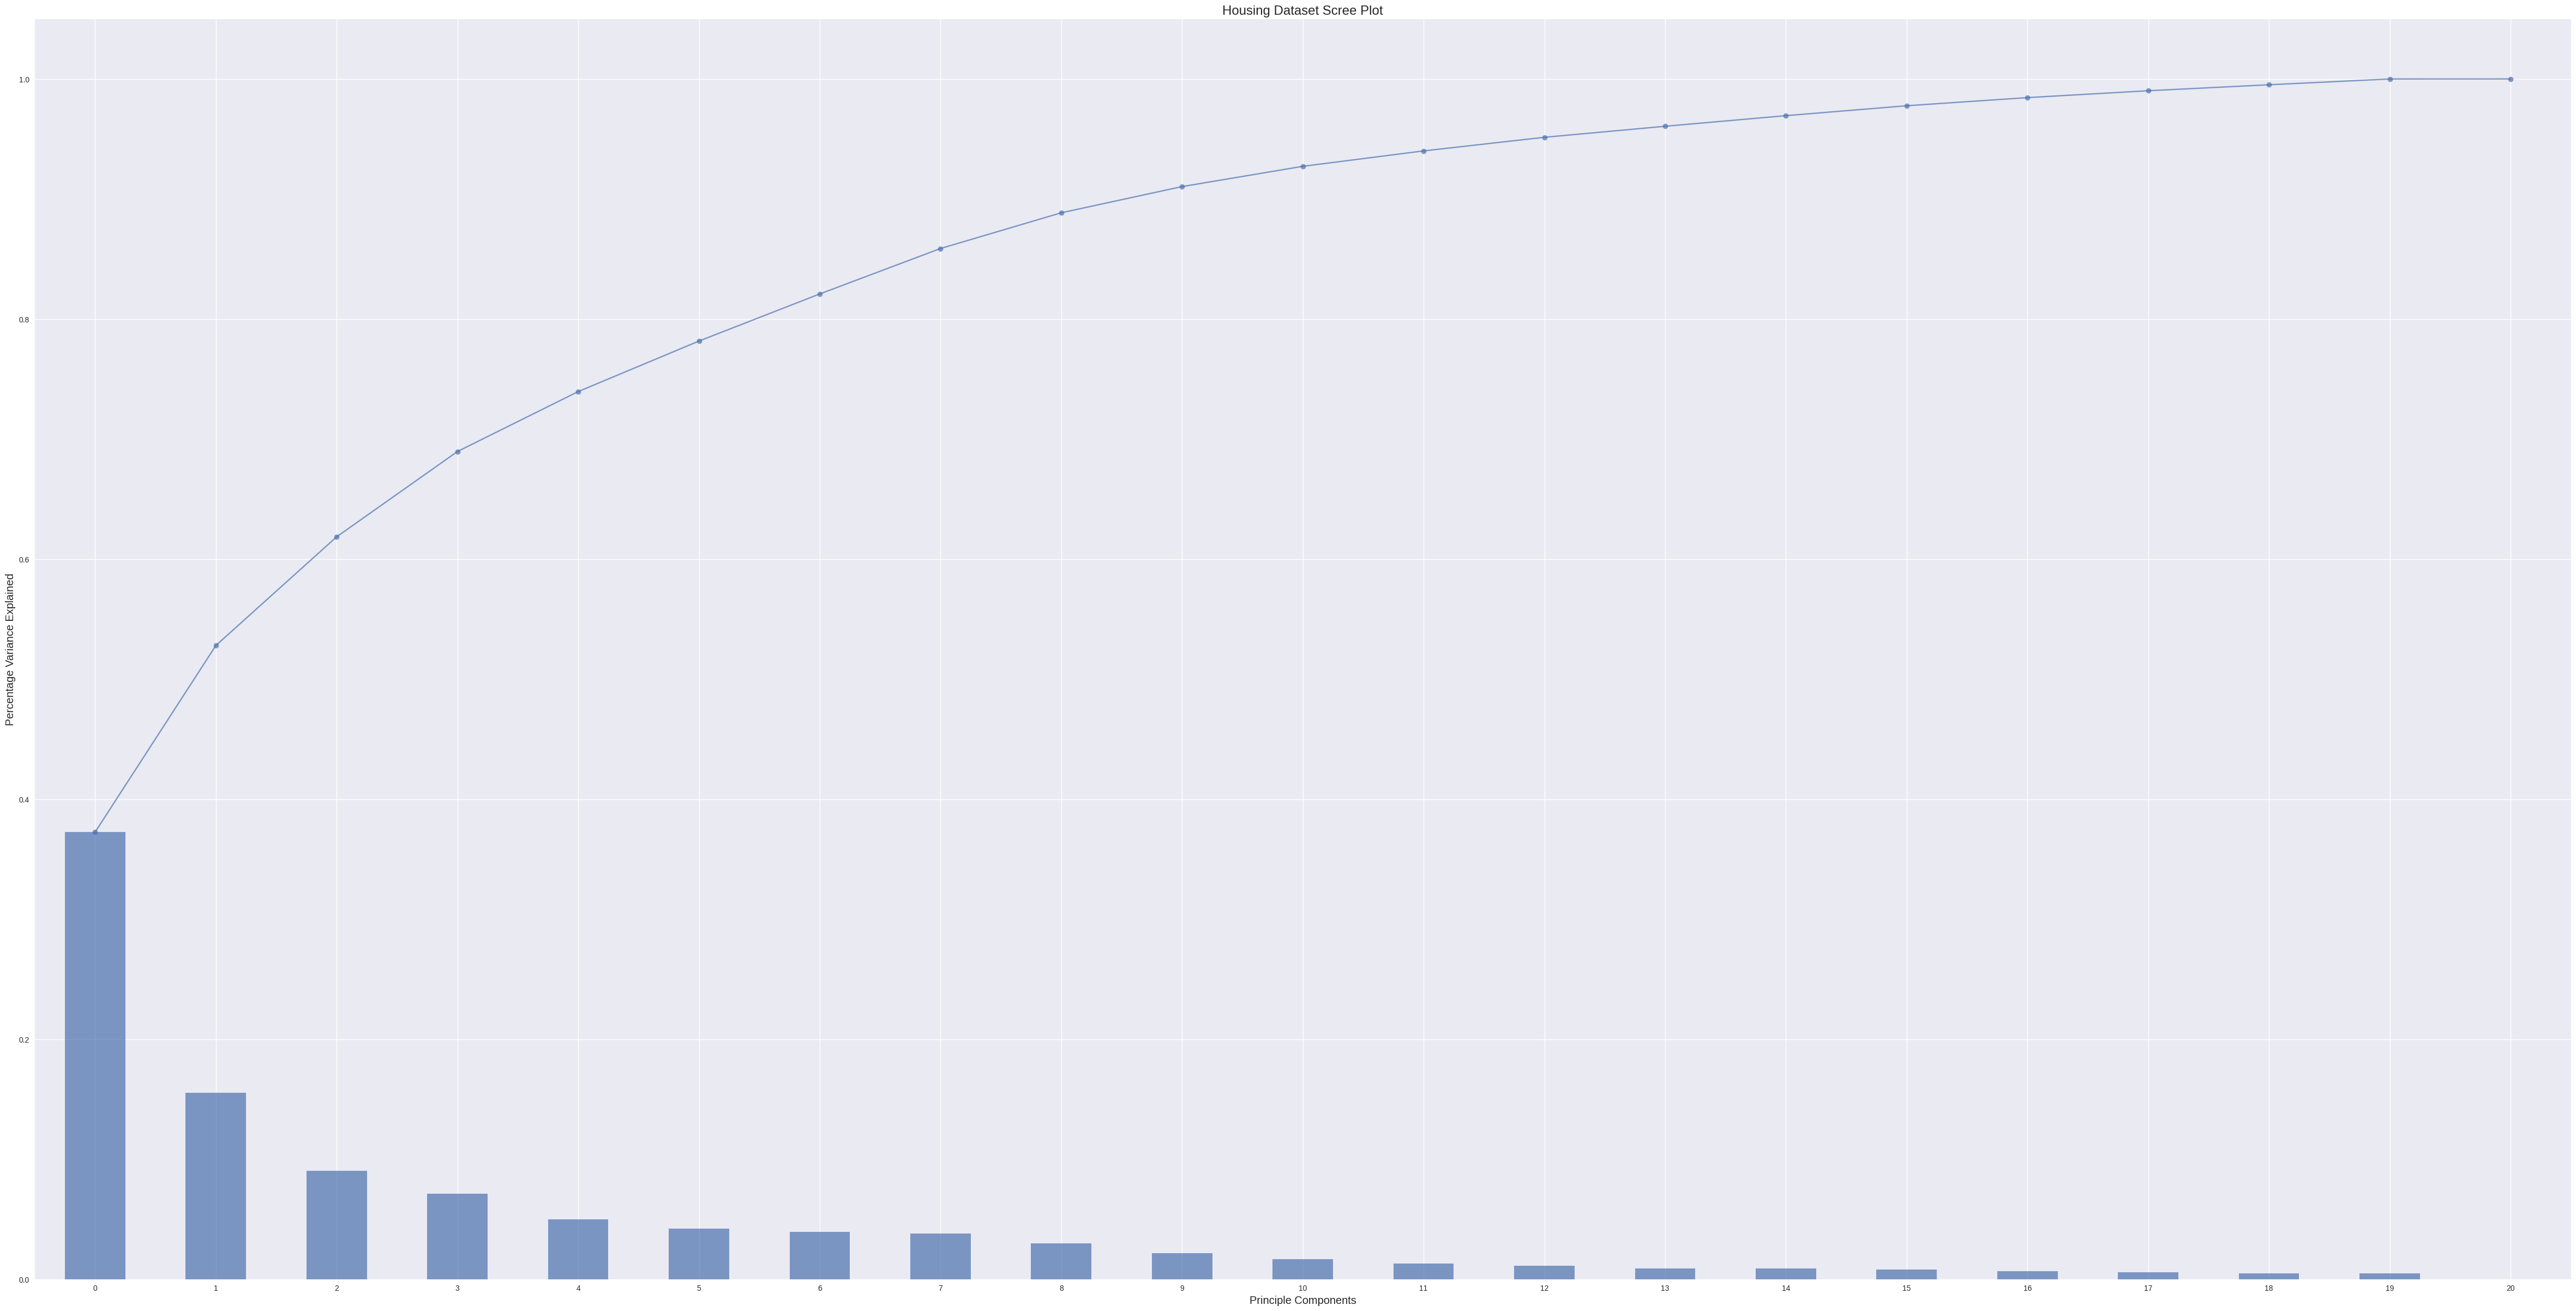

In [ ]:
# Lets visual the cummulative sum of the variances

plt.style.use("seaborn")
plt.figure(figsize=(60,30))
exp_var = pd.Series(pca.explained_variance_ratio_)

# Plot the variance for each component
exp_var.plot(kind="bar", alpha=0.7) # plot bar chart

# Calculate the amount of variance explained added by each additional component
total = 0
var_ls = []
for x in exp_var:
    total = total+x
    var_ls.append(total)

# Plot line chart of increasing variances
pd.Series(var_ls).plot(marker="o", alpha=0.7)

# Plot labels and titles
plt.xlabel("Principle Components", fontsize="x-large")
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("Housing Dataset Scree Plot", fontsize="xx-large")
plt.show();

From looking at the graph above, I will use 95% of components.

### Splitting Train and Test data

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Scaling split data for PCA 95%

In [ ]:
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

### Fitting PCA 95% on split data

In [ ]:
# fit PCA
pca95 = PCA (n_components=.95)
X_train_pca = pca95.fit_transform(X_train_sc)
X_test_pca = pca95.transform(X_test_sc)



## Model 1 (100 nodes)

### Getting amount of columns for input layer

In [ ]:
X_train_pca.shape[1]

16

### Creating Model

In [ ]:
# create model architecture
input_dim = X_train_pca.shape[1]

reg_model = Sequential()

reg_model.add(Dense(100, input_dim=input_dim, activation='relu'))
reg_model.add(Dense(100, activation='relu'))
reg_model.add(Dense(1, activation='linear'))

reg_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1700      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11,901
Trainable params: 11,901
Non-trainable params: 0
_________________________________________________________________


### Compile model with additional metrics

In [ ]:
reg_model.compile(loss='mse', optimizer='adam', metrics=[metrics.MeanAbsoluteError(),  metrics.RootMeanSquaredError()])


### Training for 100 epochs

In [ ]:
# fitting our model
history = reg_model.fit(X_train_pca, y_train, validation_data = (X_test_pca, y_test), epochs=100, verbose=0)

###  Applying the custom function plot_history() to see how our model is doing

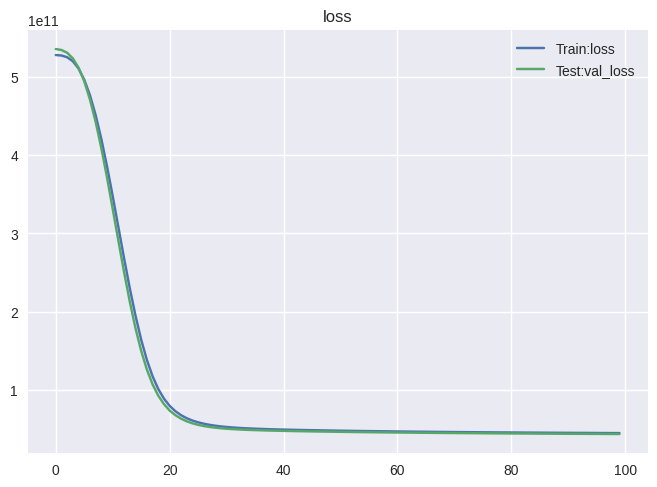

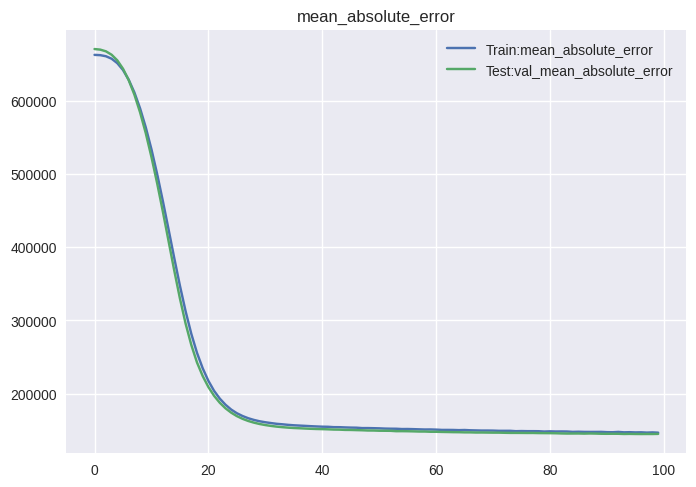

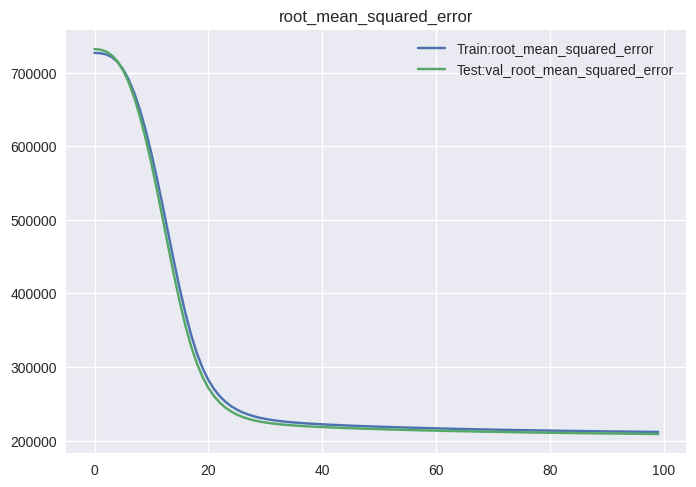

In [ ]:
plot_history(history)

### Evaluation

In [ ]:
train_scores = eval_regression(reg_model, X_train_pca, y_train, name='Train')
test_scores = eval_regression(reg_model, X_test_pca, y_test, name='Test')
scores = pd.concat([train_scores, test_scores])
scores

39/39 [==============================] - 0s 1ms/step


,MAE,RMSE,R2
Train,147262.336380,211606.910752,0.499079
Test,145277.189662,208948.778362,0.495074


The errors way too large, for the next model we will include regularization of early stopping.

## Model 2 (100 nodes) with Regularization (Early Stopping)

In [ ]:
reg_model2 = Sequential()

reg_model2.add(Dense(100, input_dim=input_dim, activation='relu'))
reg_model2.add(Dense(100, activation='relu'))
reg_model2.add(Dense(1, activation='linear'))

reg_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               1700      
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11,901
Trainable params: 11,901
Non-trainable params: 0
_________________________________________________________________


###  Compiling with addtional metrics

In [ ]:
reg_model2.compile(loss='mse', optimizer='adam', metrics=[metrics.MeanAbsoluteError(),  metrics.RootMeanSquaredError()])

### Training with 100 epochs and Regularization

In [ ]:
# Regularization
early_stopping = EarlyStopping(patience = 5)

# fitting our model
history2 = reg_model2.fit(X_train_pca, y_train, validation_data = (X_test_pca, y_test), epochs=100,callbacks = [early_stopping], verbose=0)

### Apply custom function to see how its doing

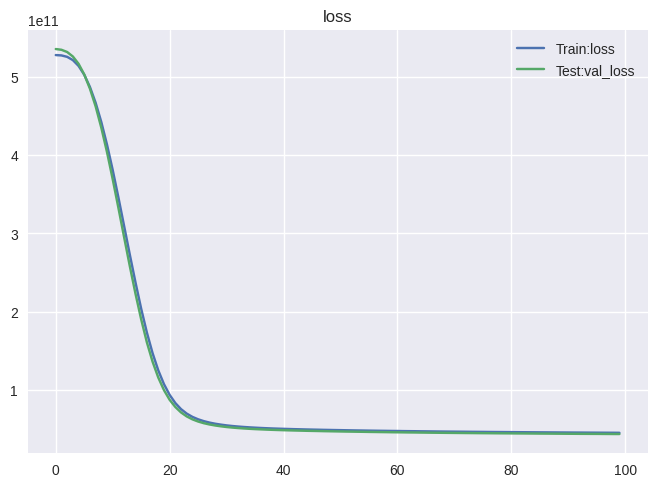

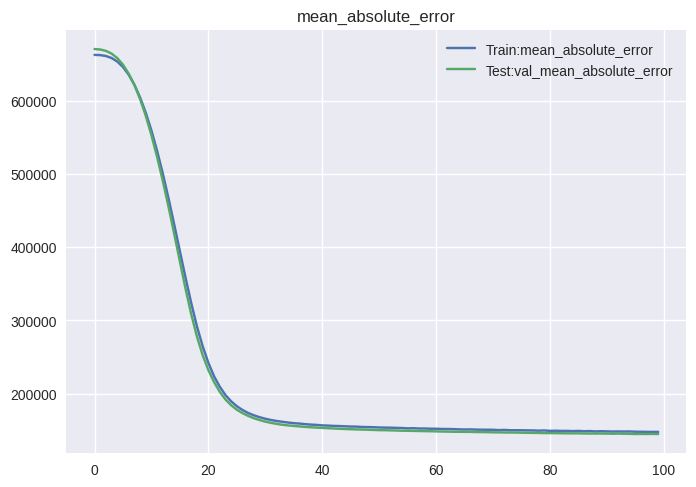

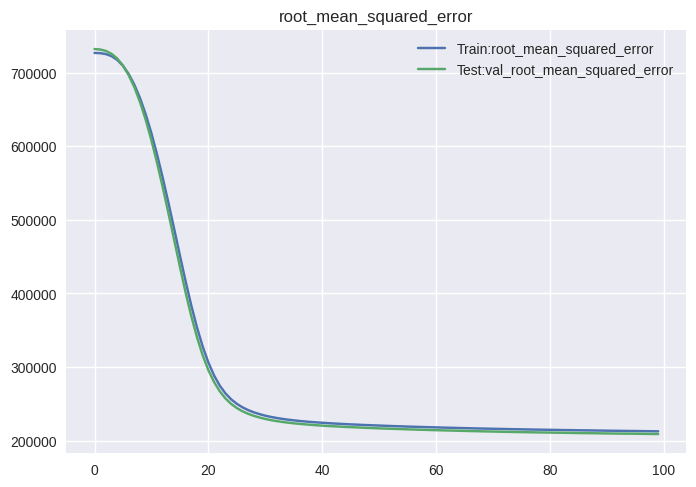

In [ ]:
plot_history(history2)

### Evaluation

In [ ]:
train_scores2 = eval_regression(reg_model2, X_train_pca, y_train, name='Train')
test_scores2 = eval_regression(reg_model2, X_test_pca, y_test, name='Test')
scores2 = pd.concat([train_scores2, test_scores2])
scores2

39/39 [==============================] - 0s 1ms/step


,MAE,RMSE,R2
Train,147908.534815,212614.269792,0.494298
Test,145119.376302,209092.190892,0.494381


With the plots above we can see that the variance increases later on, we will further decrease the nodes for the 3rd model below and apply regularization.

## Model 3 (40 nodes)

In [ ]:
reg_model3 = Sequential()

reg_model3.add(Dense(100, input_dim=input_dim, activation='relu'))
reg_model3.add(Dense(100, input_dim=input_dim, activation='relu'))
reg_model3.add(Dense(100, input_dim=input_dim, activation='relu'))
reg_model3.add(Dense(100, input_dim=input_dim, activation='relu'))
reg_model3.add(Dense(1, activation='linear'))

reg_model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               1700      
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 32,101
Trainable params: 32,101
Non-trainable params: 0
_________________________________________________________________


###  Compiling with addtional metrics

In [ ]:
reg_model3.compile(loss='mse', optimizer='adam', metrics=[metrics.MeanAbsoluteError(),  metrics.RootMeanSquaredError()])

### Training with 100 epochs

In [ ]:
# fitting our model
history3 = reg_model3.fit(X_train_pca, y_train, validation_data = (X_test_pca, y_test), epochs=100, verbose=0)

### Apply custom function to see how its doing

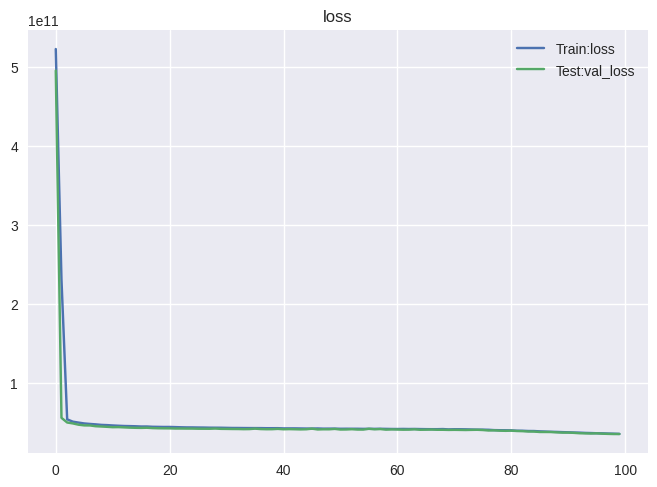

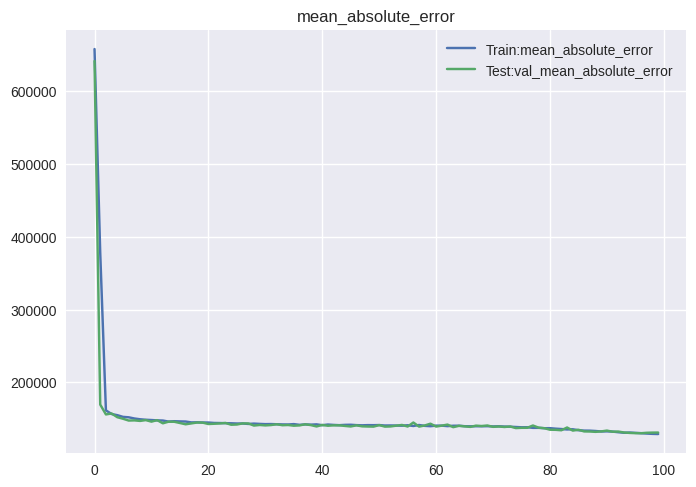

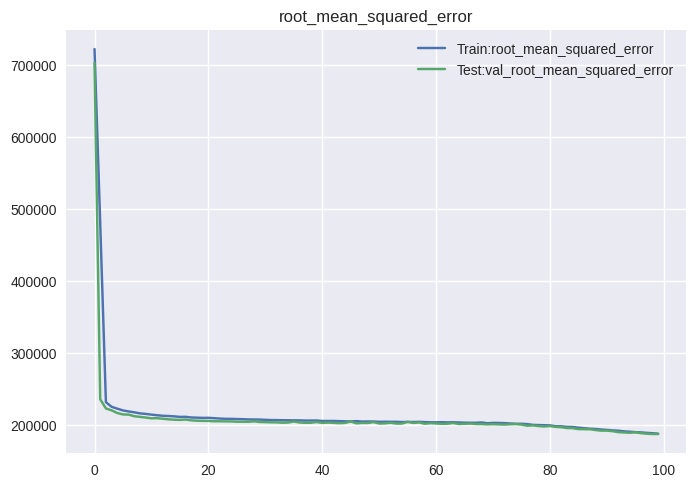

In [ ]:
plot_history(history3)

### Evaluation

In [ ]:
train_scores3 = eval_regression(reg_model3, X_train_pca, y_train, name='Train')
test_scores3 = eval_regression(reg_model3, X_test_pca, y_test, name='Test')
scores3 = pd.concat([train_scores3, test_scores3])
scores3

39/39 [==============================] - 0s 2ms/step


,MAE,RMSE,R2
Train,128692.322004,186773.146759,0.609754
Test,130979.906471,187558.115720,0.593164


## Final Evaluation

In [ ]:
print('---Model 1---\n')
print(scores)
print('\n---Model 2---\n')
print(scores2)
print('\n---Model 3---\n')
print(scores3)

---Model 1---

                 MAE           RMSE        R2
Train  147262.336380  211606.910752  0.499079
Test   145277.189662  208948.778362  0.495074

---Model 2---

                 MAE           RMSE        R2
Train  147908.534815  212614.269792  0.494298
Test   145119.376302  209092.190892  0.494381

---Model 3---

                 MAE           RMSE        R2
Train  128692.322004  186773.146759  0.609754
Test   130979.906471  187558.115720  0.593164


The best performing model was the 3rd model.  It had the lowest error compared to the other models.  Model 1 performed the worst and was overfitting.  I select Model 3